In [15]:
import pandas as pd
import pandas_datareader.data as web
import datetime

def gather_data(data_codes, #dict
                start, #start date (datetime)
                end = datetime.datetime.today(), #end date (datetime)
               freq="M"): #str "D","W","M","Q","A", also "2D", etc...
    df_init = False
    for name, code in data_codes.items():
        if df_init == False:
            # .resample(freq) adjusts frequency, 
            #   choose .first(), .last(). mean(), median(), etc...
            df = web.DataReader(
                code, "fred", start, end).resample(freq).mean()
            df.rename(columns = {code:name}, inplace = True)
            df_init = True
        else:
            df[name] = web.DataReader(
                code, "fred", start, end).resample(freq).mean()
    return df

def bil_to_mil(series):
    return series * 10 ** 3

start = datetime.datetime(1970,1,1)
end = datetime.datetime.today()
freq = "M"

In [16]:
from datlib.plots import *
# from datlib.FRED import *

data_codes= {"Monetary Base":"BOGMBASE",
            "Currency in Circulation":"WCURCIR"}
base = gather_data(data_codes,
                  start,
                  end,
                  freq)


In [17]:
base

,Monetary Base,Currency in Circulation
DATE,,
1970-01-31,76400.0,NaN
1970-02-28,75200.0,NaN
1970-03-31,75300.0,NaN
1970-04-30,76300.0,NaN
1970-05-31,76600.0,NaN
...,...,...
2021-04-30,6042100.0,2154.81925
2021-05-31,6041900.0,2167.94475
2021-06-30,6027100.0,2178.90020


In [ ]:
data_codes  = {"Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Mil)": "WCURCIR",
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Excess Reserves ($ Mil)": "EXCSRESNW",
               "Balance Sheet: Required Reserves ($ Mil)": "RESBALREQW",
               "Balance Sheet: Total Reserves ($ Mil)": "WRESBAL",
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Interest Rates
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER",
               # Req Reserves and Vault Cash
               "Vault Cash ($ Mil)": "TLVAULTW",
               "Vault Cash Used as Req. ($ Mil)": "VAULT",
               }

data = gather_data(data_codes = data_codes,
                  start = start,
                  end = end,
                  freq = "M")


In [19]:
bil_to_mil_list = ["Balance Sheet: Total Reserves ($ Mil)",
                  "Balance Sheet: Other Deposits ($ Mil)",
                  "Base: Currency in Circulation ($ Mil)"]
for key in bil_to_mil_list:
    data[key] = bil_to_mil(data[key])

<AxesSubplot:xlabel='DATE'>

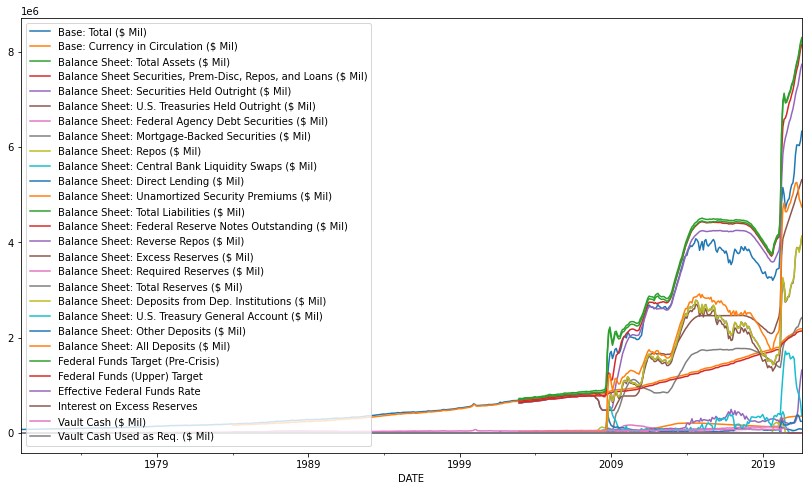

In [21]:
fig, ax = plt.subplots(figsize = (14,8))
data.plot(ax = ax)